In [20]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt

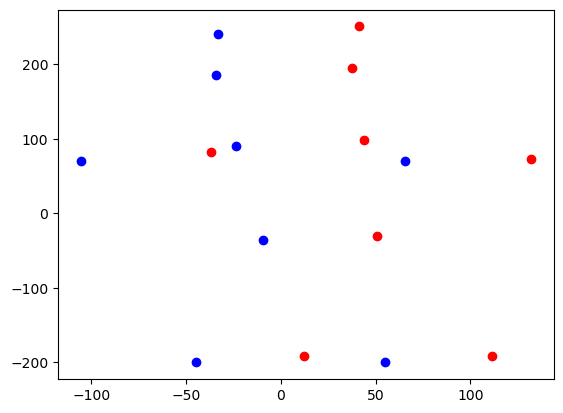

In [34]:
path = r'D:\StageE23\Data\Ete_2023\Participant19'

json_corr = open(os.path.join(path, r'Corrected\Prise01\Positions\positions_xyzr.json'))
pos_corr = json.load(json_corr)

json_auto = open(os.path.join(path, r'autocorrection\Prise01\Positions\positions_xyzr.json'))
pos_auto = json.load(json_auto)

x_corr, y_corr, z_corr = [], [], []
x_auto, y_auto, z_auto = [], [], []

for corr, auto in zip(pos_corr.values(), pos_auto.values()):
    x_corr, y_corr, z_corr = [], [], []
    x_auto, y_auto, z_auto = [], [], []
    for c_corr, c_auto in zip(corr.values(), auto.values()):
        x_corr.append(c_corr[0])
        y_corr.append(c_corr[1])
        z_corr.append(c_corr[2])
        x_auto.append(c_auto[0])
        y_auto.append(c_auto[1])
        z_auto.append(c_auto[2])
    
plt.scatter(x_auto, y_auto, c='b')
plt.scatter(x_corr, y_corr, c='r')
plt.show()

In [93]:
array_auto = np.array([x_auto, y_auto, z_auto])
array_corr = np.array([x_corr, y_corr, z_corr])

#while not np.allclose(array_auto, array_corr, atol = 50):
# Calcule les centrïdes
auto_centro = np.mean(array_auto, axis=1).reshape((-1,1))
corr_centro = np.mean(array_corr, axis=1).reshape((-1,1))

# Soustrait les centroïdes des coordos
q_auto = array_auto - auto_centro
q_corr = array_corr - corr_centro

# Matrice de covariance
H = np.matmul(q_corr, q_auto.transpose())
U, X, V_t = np.linalg.svd(H) # SVD de la matrice de covariance

# Matrice de rotation
R = np.matmul(V_t.transpose(), U.transpose())
print(np.linalg.det(R))
#assert np.allclose(np.linalg.det(R), 1.0)

# Matrice de translation
T = auto_centro - np.matmul(R, corr_centro)
print(T)

array_corr = T + np.matmul(R, array_corr)


-1.0000000000000002
[[816.05954898]
 [-50.51474637]
 [-76.90038199]]


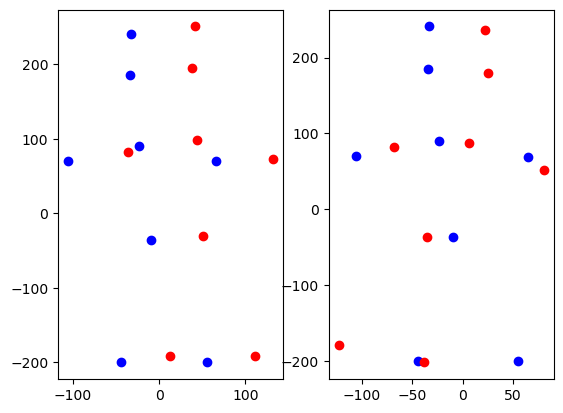

[1451.48689365 1394.17502981 1391.49255156 1423.80271973 1425.03776646
 1427.09653859 1411.94344344 1427.13149062]
[1470.28589655 1442.67193446 1418.22423704 1419.43134671 1437.24886665
 1361.8159916  1424.0587753  1378.42938555]


In [94]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.scatter(x_auto, y_auto, c='b')
ax1.scatter(x_corr, y_corr, c='r')
ax2.scatter(x_auto, y_auto, c='b')
ax2.scatter(array_corr[0,:], array_corr[1,:], c='r')
plt.show()

print(array_auto[2])
print(array_corr[2])